In [1]:
####
#### Please, do NOT commit PosrecTest changes without deleting all the output first!!
#### We don't want all versions of the plots to be stored in the git repository
####

In [2]:
import os
from time import strftime
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

from pax import core, utils, datastructure, simulation, units
from pax.plugins.io.WaveformSimulator import uniform_circle_rv

In [3]:
##
# Simulation settings
##

n_pe = 1300
n_trials = int(4e4)

# Cap hitpatterns at a certain value (adjusted for gain variations) to simulate saturation
# Much easier than going through the whole waveform simulation process!
# 9k is what Sander found when studying saturation 
max_area_per_pmt = 9000

# Plugin (file, name)s to test
plugins_to_test = [
    ('MaxPMT', 'PosRecMaxPMT'),
    ('WeightedSum', 'PosRecWeightedSum'),
    ('NeuralNet', 'PosRecNeuralNet'),
    ('RobustWeightedMean', 'PosRecRobustWeightedMean'),
    ('TopPatternFit', 'PosRecTopPatternFit'),
]


##
# Data and plots settings
##

# Fiducial volume from xenon:xenon100:analysis:run10:fv, function above fig 3
fiducial_volume_radius = np.sqrt(19481*units.mm**2)

# Size multiplier for all plots
size_multiplier = 1.5

# To save plots to png and/or pdf, set to true
save_plots=True
save_pdf_plots=False

# Saves plots to plots/YYMMDD/...
plot_folder = os.path.join("posrectest_plots", strftime("%Y%m%d"))

/home/ioana/src/xenon/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


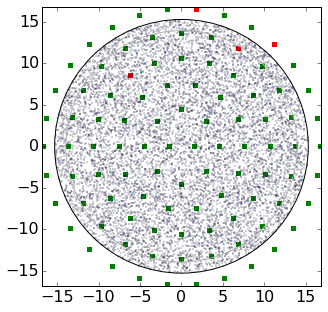

In [15]:
##
# Initializiation
##
mypax = core.Processor(config_names=['XENON100'], config_dict={
    'pax': {
            'plugin_group_names': ['test'],
            'test':               ["%s.%s" % (a, b) for a, b in plugins_to_test],},
    'WaveformSimulator': {
            's2_patterns_zoom_factor': 4,
            'magically_avoid_dead_pmts': False,
            'randomize_fraction_of_s2_top_array_photons': 0,
    },
    'TopPatternFit.PosRecTopPatternFit': {
            'plot_position': False,  # if True makes a plot of each reconstructed position
            'confidence_levels': [2.3, 6.18],  # Values correspond to [1sigma CL, 2sigma CL] for chi2gamma
                                               # Remember to use a s2_patterns_zoom_factor of at least 4
    }
})
sim = mypax.simulator
posrec_plugins = [mypax.get_plugin_by_name(name) for filename, name in plugins_to_test]

# Calculate the gain variation per PMT in pe
# Dead pmts give a 'nan' gain sigma: put at mean of others
gains = np.array(sim.config['gains'])
dead_pmts = np.where(gains == 0)[0]
gain_sigmas = np.array(sim.config['gain_sigmas'])/gains
gains[dead_pmts] = 0
gain_sigmas[dead_pmts] = 0

max_pe_per_ch = np.array([max_area_per_pmt / max(1e-9, sim.config['gains'][ch] / 2e6)
                          for ch in range(sim.config['n_channels'])])
max_pe_per_ch[dead_pmts] = float('inf')   # Don't want to do saturation clipping in dead PMTs


def euclideandifference(x1, x2, y1, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def save_plot(title):
    title += "_%dtrials" % n_trials
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)
    if save_pdf_plots:
        plt.savefig(os.path.join(plot_folder, title) + '.pdf', format='pdf')
    if save_plots:
        plt.savefig(os.path.join(plot_folder, title) + '.png', format='png', dpi=300)
        
def plot_pmts(pmt_range, color, marker='x', s=20):
    plt.scatter([sim.config['pmt_locations'][i]['x'] for i in pmt_range], 
                [sim.config['pmt_locations'][i]['y'] for i in pmt_range],
                marker='s', s=s, facecolor=color, edgecolors='white')

def plot_top_array():
    plot_pmts([ch for ch in sim.config['channels_top'] if ch in dead_pmts and ch != 0],
              s=40, color='red')
    plot_pmts([ch for ch in sim.config['channels_top'] if ch not in dead_pmts],
              s=40, color='green')

def plot_detector_radius():
    plt.xlim((-1.1*detector_radius, 1.1*detector_radius))
    plt.ylim((-1.1*detector_radius, 1.1*detector_radius))

    plt.gca().add_artist(plt.Circle((0,0), 
                                    detector_radius, 
                                    edgecolor='black', 
                                    fill=None))
    plt.gca().add_artist(plt.Circle((0,0), 
                                    fiducial_volume_radius, 
                                    edgecolor='0.7',
                                    fill=None))

def bin_centers(bin_edges):
    return 0.5*(bin_edges[1:] + bin_edges[:-1])

# Check that sampling algorithm is correct
detector_radius = sim.config['tpc_radius']
detector_length = sim.config['tpc_length']
xs, ys = uniform_circle_rv(detector_radius, 10000)
plt.figure(figsize=(5,5))
plot_detector_radius()
plt.scatter(xs, ys, s=1, edgecolor=None, alpha=0.2)
plt.show()

In [22]:
##
# Run simulator
##
rps = defaultdict(list)
xs, ys = np.array(uniform_circle_rv(detector_radius, n_trials))
zs = np.random.uniform(-detector_length, 0, n_trials)
position_errors = []


for trial_i in tqdm(range(n_trials)):
    x = xs[trial_i]
    y = ys[trial_i]
    z = zs[trial_i]
    # Let pax's simulator do the magic
    hitp = sim.distribute_photons(n_pe, x, y, z).astype(np.float64)
    
    # Replace the above line with the code below to the test the full photon time distribution logic
    # Causes a ~5x slowdown for 100k pe, hardly noticeable at 1300 pe
    #     shp = simulation.SimulatedHitpattern(simulator=sim, 
    #                                          photon_timings=np.zeros(n_pe), 
    #                                          x=x, y=y, 
    #                                          z=-sim.config['gate_to_anode_distance'])
    #     hitp = np.array([len(shp.arrival_times_per_channel.get(ch, []))
    #                      for ch in range(sim.config['n_channels'])])
    
    # Dead PMTs see nothing
    hitp[dead_pmts] = 0
    
    # Clip hitpattern to simulate saturation
    # Much easier than going through the whole waveform simulation process
    is_ch_saturated = hitp > max_pe_per_ch
    hitp[is_ch_saturated] = max_pe_per_ch[is_ch_saturated]

    # Apply gain variation in each PMT
    hitp += np.random.normal(0, 1, len(hitp)) * gain_sigmas * hitp**0.5
    
    # Create fake event for the posrec plugins
    e = datastructure.Event.empty_event()
    e.peaks.append(datastructure.Peak({'type':  'S2',
                                       'detector':  'tpc',
                                       'n_saturated_per_channel': is_ch_saturated.astype(np.int16),
                                       'area_per_channel': hitp}))

    # Run posrec plugins, collect results
    for pp in posrec_plugins:
        e = pp.transform_event(e)
        rp = e.peaks[0].reconstructed_positions[-1]
        if not rp.algorithm == pp.name:
            raise ValueError("Invalid posrec algorithm %s, should be %s" % (rp.algorithm, pp.name))
        rps[pp.name].append((rp.x, rp.y))
        if pp.name == "PosRecTopPatternFit":
            position_errors.append(rp.confidence_tuples)

# Convert position list of tuples to numpy array, compute differences
rps = {k : np.array(v) for k,v in rps.items()}
differences = {k : euclideandifference(xs, v[:,0], ys, v[:,1]) for k,v in rps.items()}

30.5


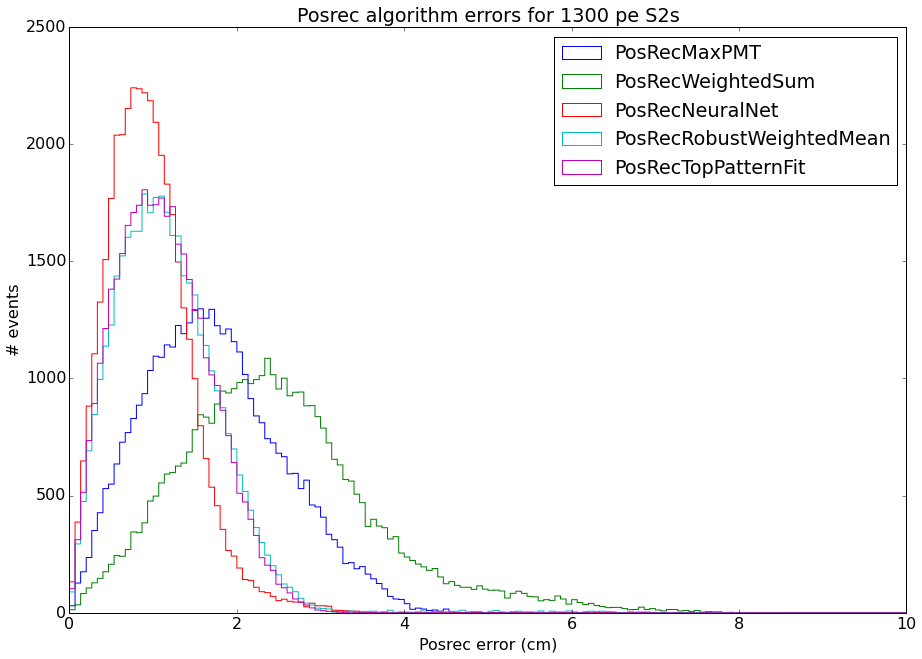

In [21]:
##
# Error histogram plot
##
plt.figure(figsize=(10*size_multiplier, 7*size_multiplier))
for pp in posrec_plugins:
    plt.hist(differences[pp.name], bins=150, range=(0, 10), histtype='step', label=pp.name)
plt.legend(loc='upper right')
plt.xlabel('Posrec error (cm)')
plt.ylabel('# events')
title = 'Posrec algorithm errors for %d pe S2s' % n_pe
plt.title(title)
save_plot(title)
plt.show()

In [7]:
# Show the mean bias for each algorithm
for pp in posrec_plugins:
    print("Mean bias vector for %s: %s cm" % (pp.name, (rps[pp.name] - np.vstack((xs, ys)).T).mean(axis=0)))

Mean bias vector for PosRecMaxPMT: [ 0.04956128 -0.14905663] cm
Mean bias vector for PosRecWeightedSum: [ 0.12756973 -0.32574359] cm
Mean bias vector for PosRecNeuralNet: [ 0.16476653  0.12968863] cm
Mean bias vector for PosRecRobustWeightedMean: [ 0.17164695 -0.38084788] cm
Mean bias vector for PosRecTopPatternFit: [ 0.13342794 -0.01356718] cm


/home/ioana/src/xenon/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


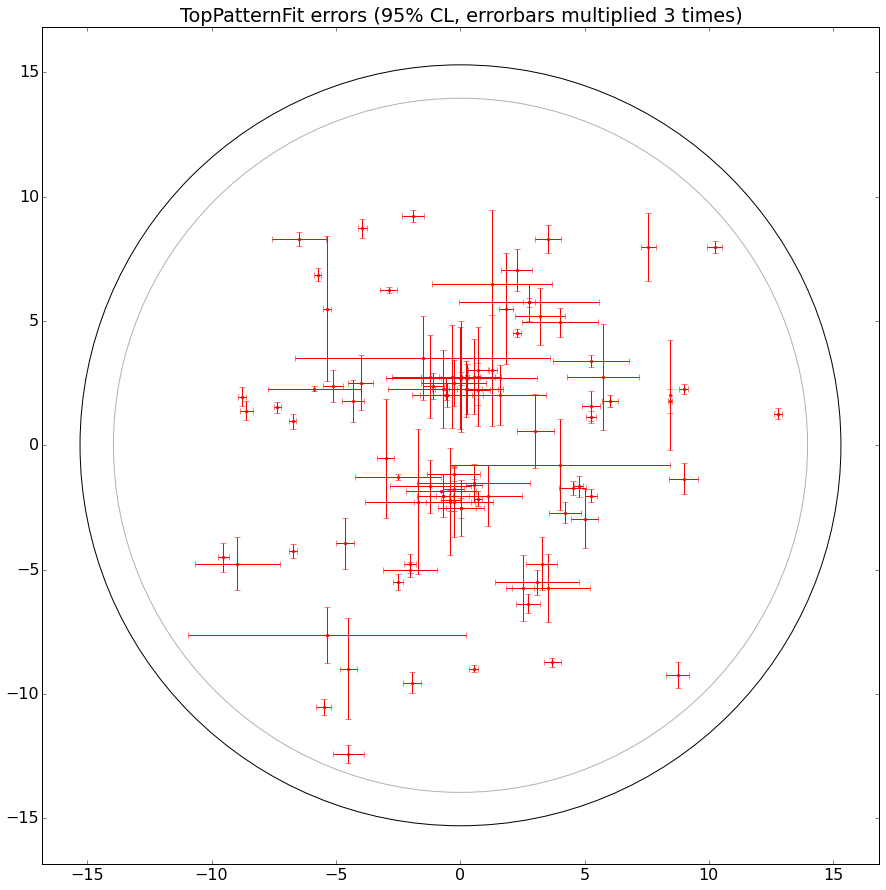

In [8]:
# TopPatternFit errors (95% CL) of first 100 events
plot_n_events = 100

if n_trials < plot_n_events:
    plot_n_events = n_trials

x = []
y = []
x_err = []
y_err = []

# Multiply errorbars by this factor
error_multiplier = 3

for i in range(plot_n_events):
    x.append(rps['PosRecTopPatternFit'][i][0])
    y.append(rps['PosRecTopPatternFit'][i][1])
    x_err.append(error_multiplier * position_errors[i][1].dx)
    y_err.append(error_multiplier * position_errors[i][1].dy)

plt.figure(figsize=(10*size_multiplier, 10*size_multiplier))

plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='r.')
plot_detector_radius()
title = 'TopPatternFit errors (95%% CL, errorbars multiplied %d times)' % error_multiplier
plt.title(title)
plt.show()

# Points that have no errorbars have one or more points of the contour outside the TPC radius.

/home/ioana/src/xenon/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


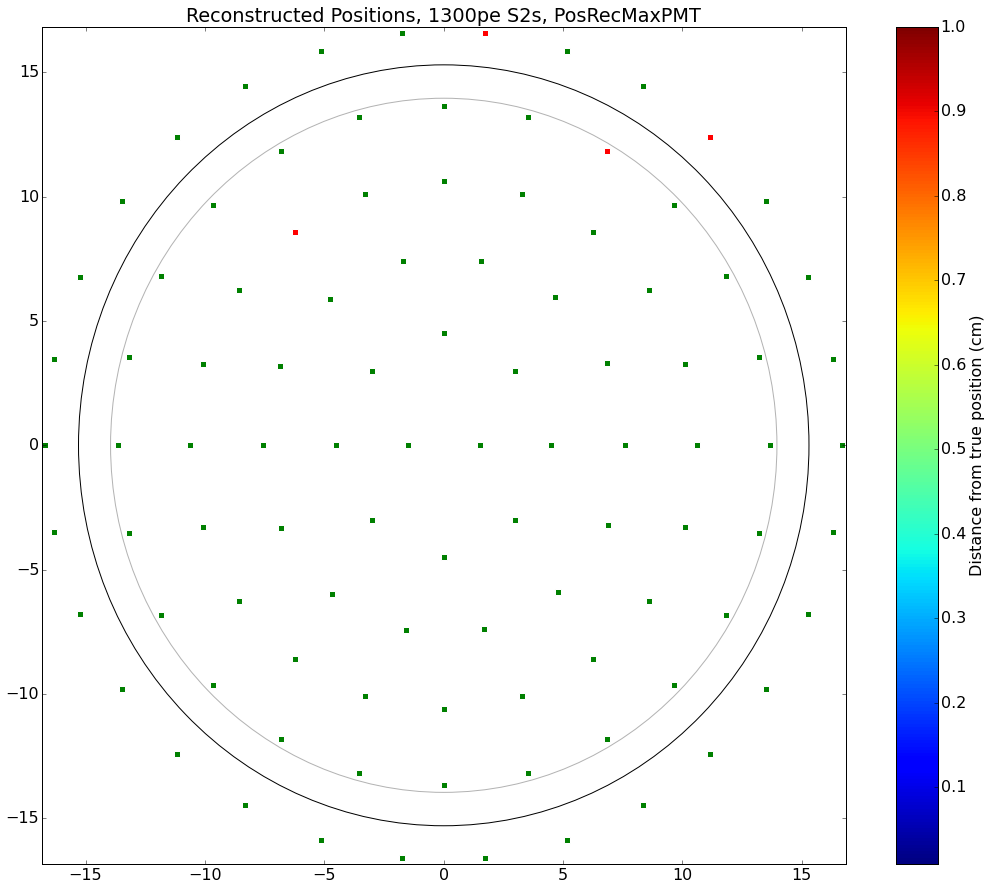

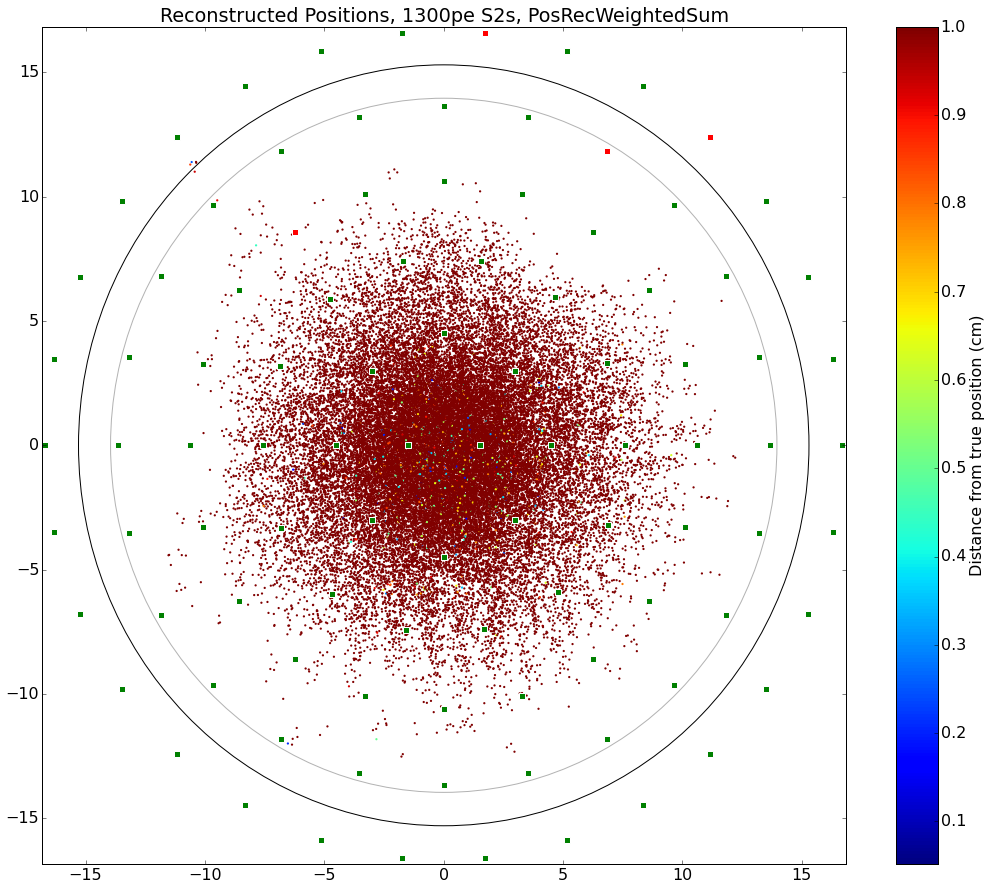

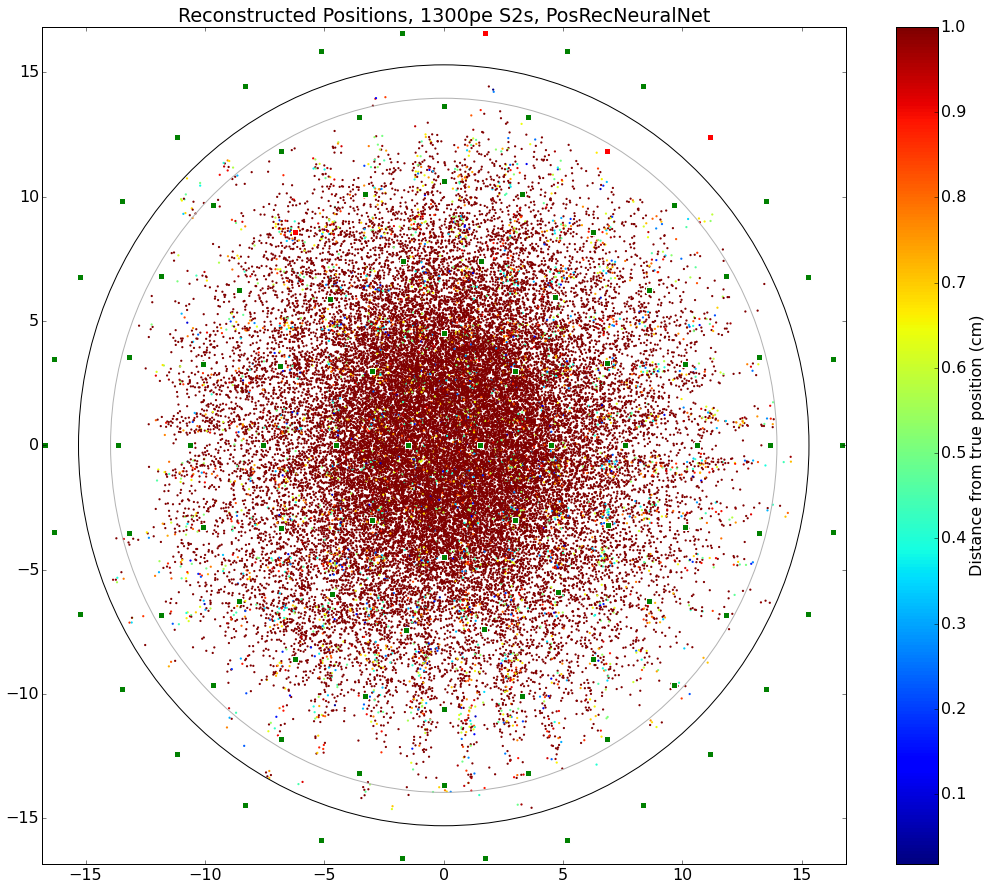

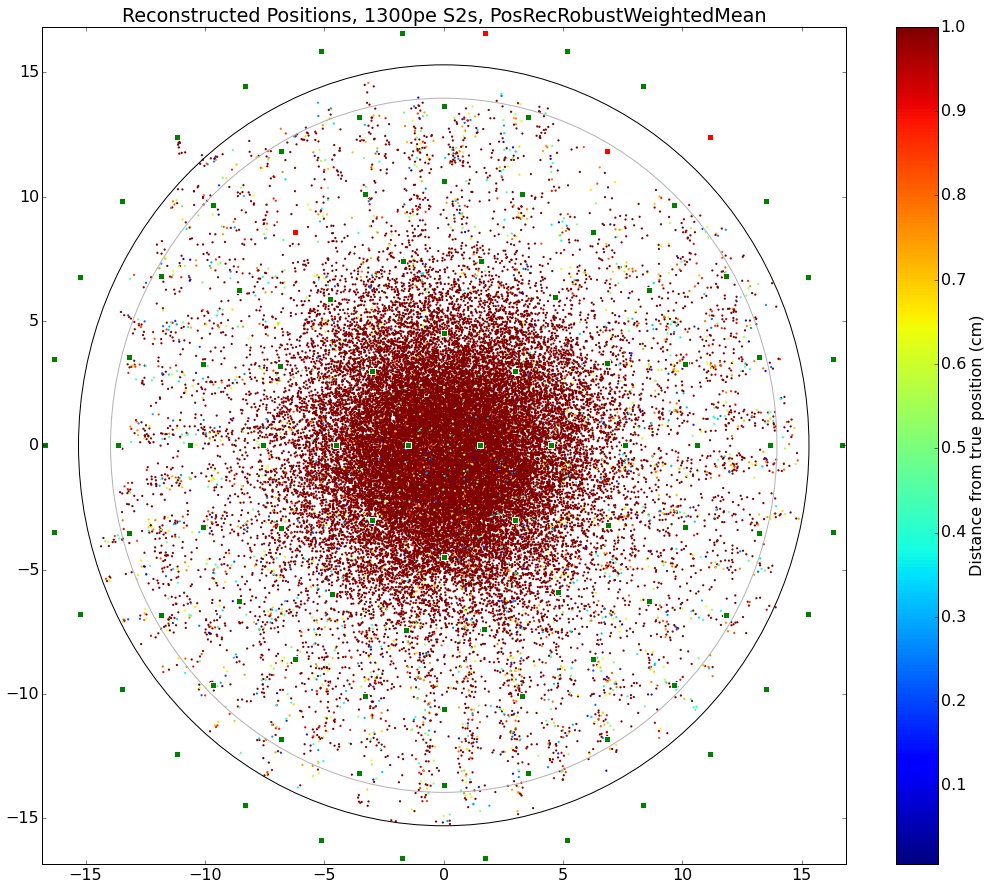

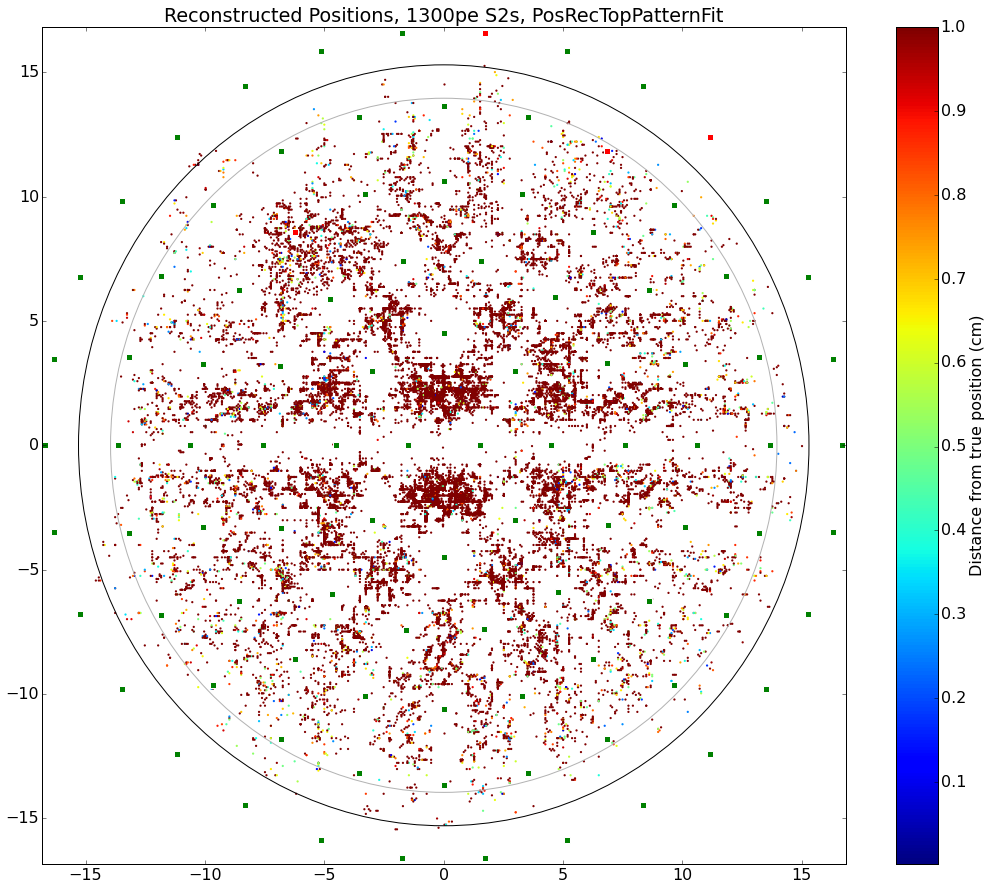

In [9]:
##
# Scatter plot of reconstructed positions
##
for pp in  posrec_plugins:
    plt.figure(figsize=(12*size_multiplier,10*size_multiplier))
    plt.scatter(rps[pp.name][:,0], rps[pp.name][:,1],
                c=differences[pp.name], marker='.', edgecolors='none', vmax=1)
    plt.colorbar(label='Distance from true position (cm)')
    plot_detector_radius()
    plot_top_array()
    title = 'Reconstructed Positions, %dpe S2s, %s' % (n_pe, pp.name)
    plt.title(title)
    save_plot(title)
    plt.show()

/home/ioana/src/xenon/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


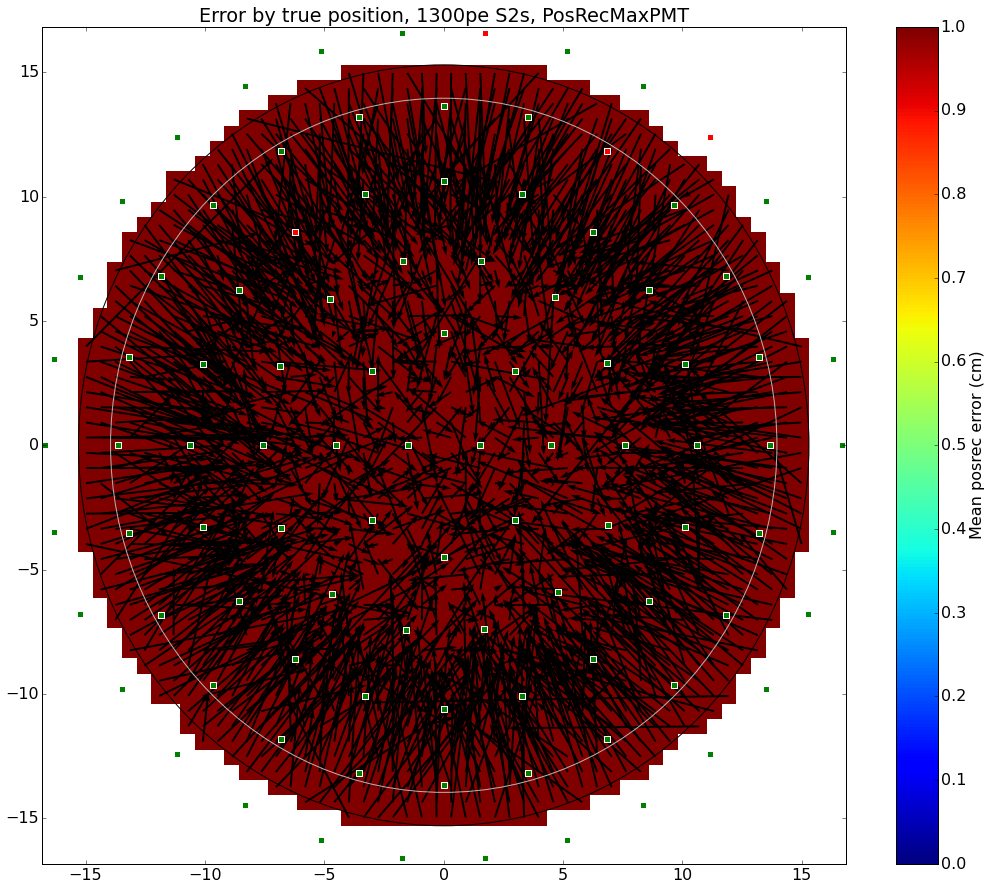

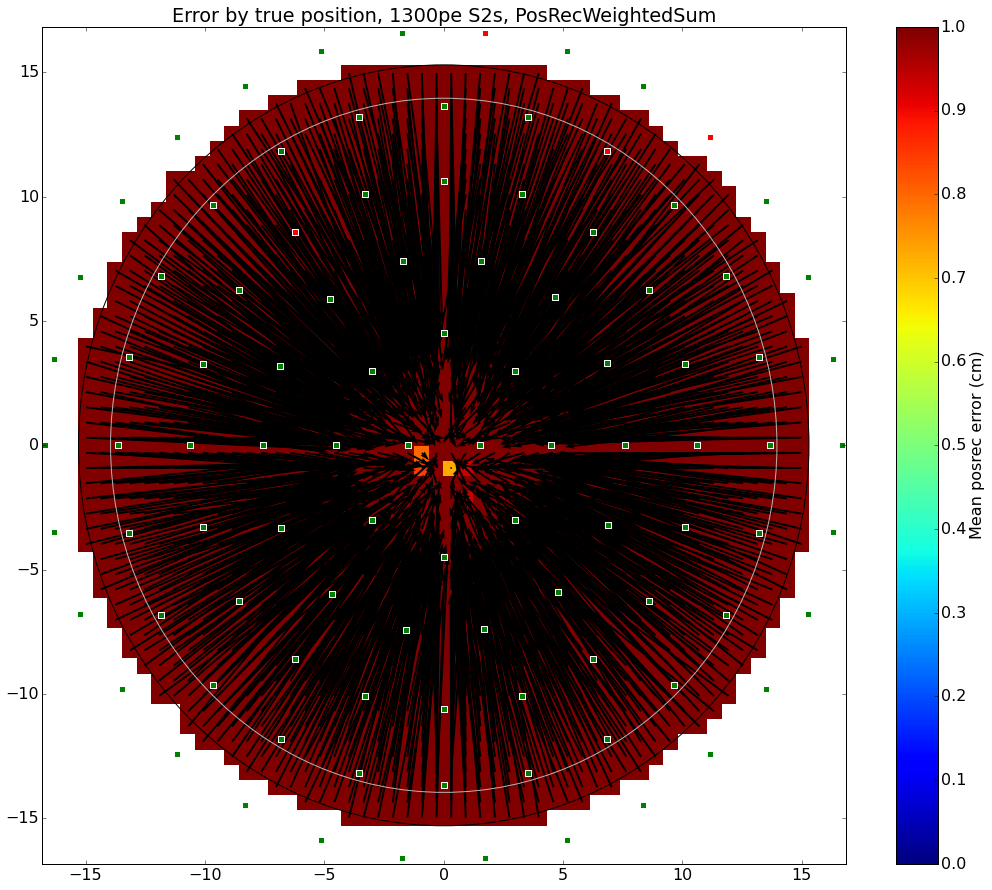

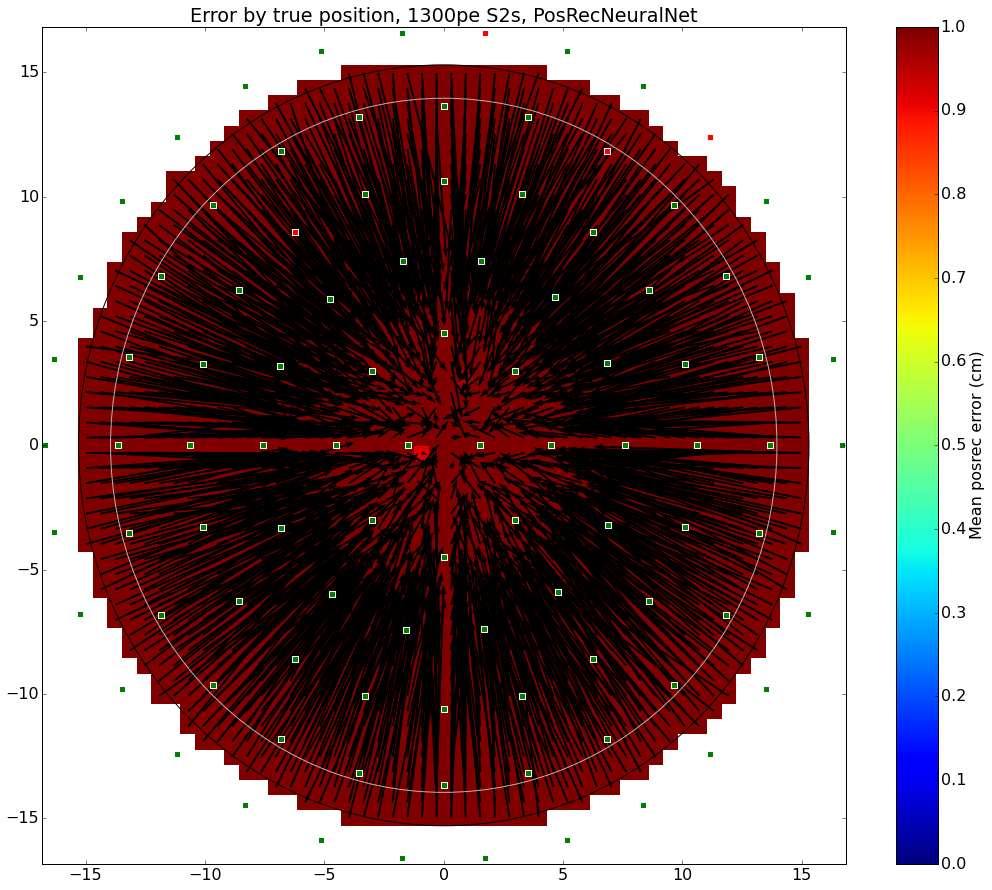

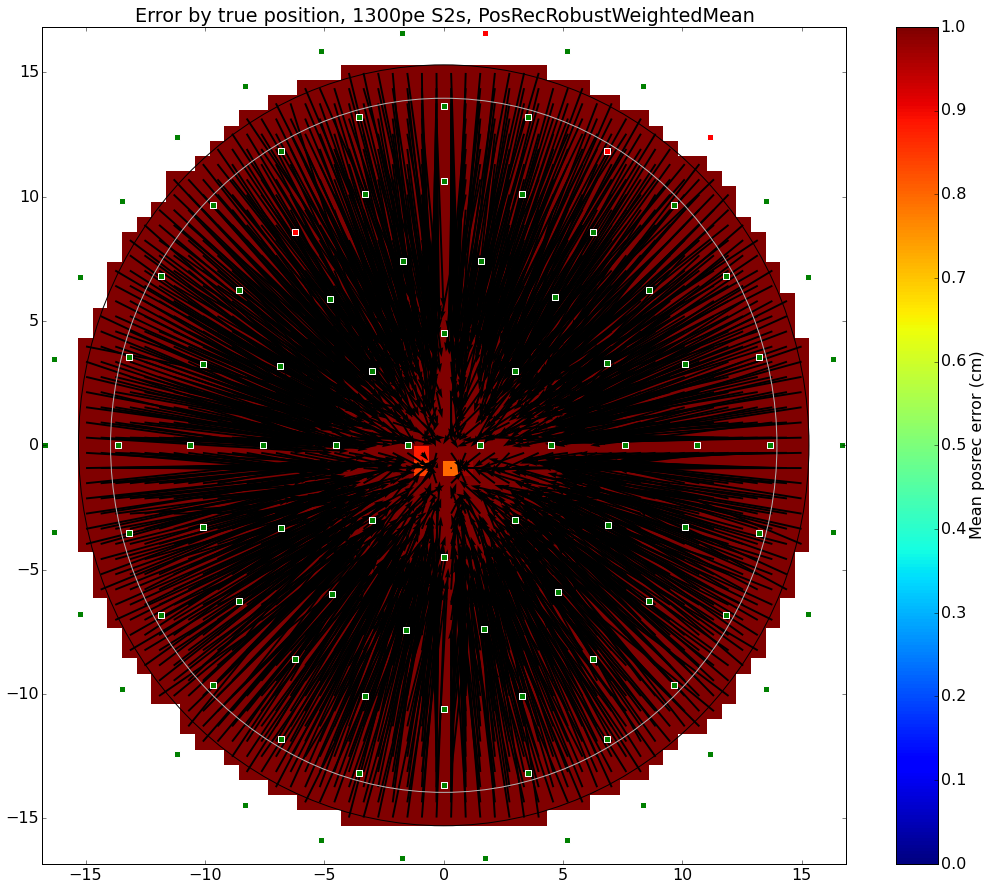

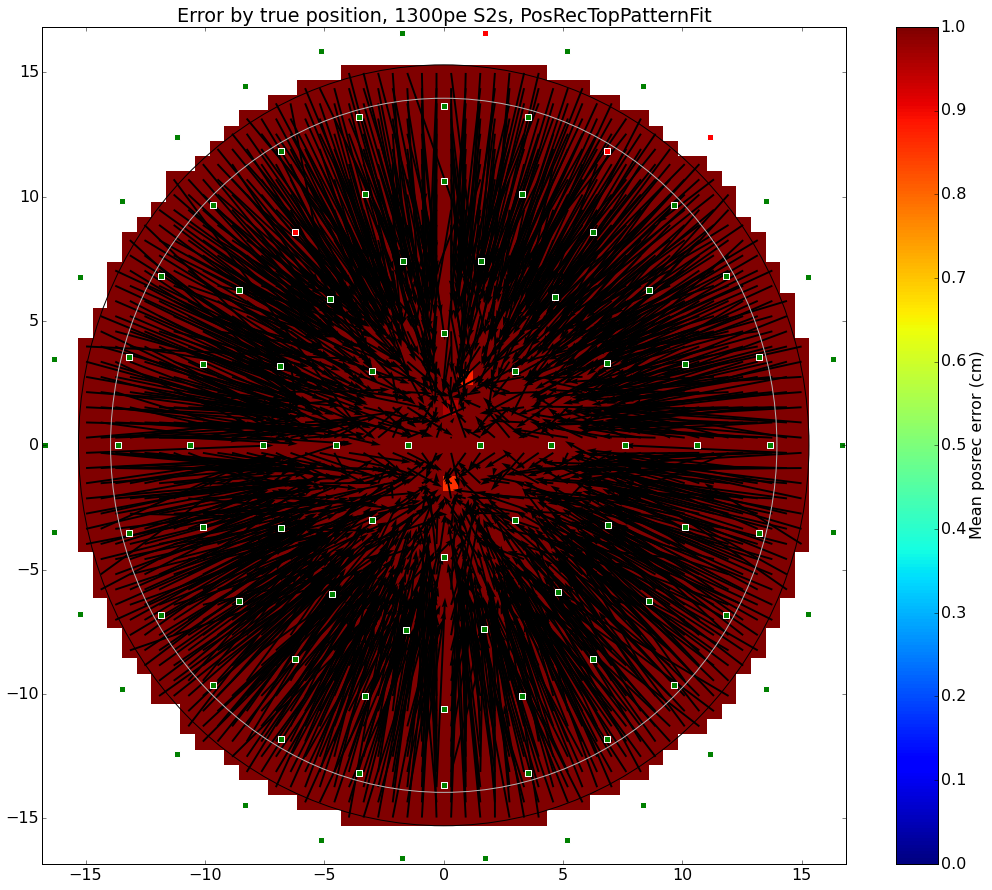

In [10]:
##
# Spatial error and bias plot
##

def twod_stat_plot(x, y, z, statistic='mean', bins=10, range=None, vrange=None, cblabel=None):
    if vrange is None:
        vrange = (None, None)
    result, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        x, y, z,
        bins=bins,
        statistic=statistic,
        range=range
    )
    xx, yy = np.meshgrid(xbinedges, ybinedges)    

    Zm = np.ma.masked_where(np.isnan(result),result)
    plt.figure(figsize=(size_multiplier*12, size_multiplier*10))
    plt.pcolormesh(xx, yy, Zm, vmin=vrange[0], vmax=vrange[1])
    plt.colorbar(label=cblabel)

for pp in posrec_plugins:
    pp_name = pp.name
    bins = 50

    twod_stat_plot(ys, xs, differences[pp_name],
                   bins=bins, vrange=(0, 1),                   
                   cblabel='Mean posrec error (cm)')
    
    twod_difs = rps[pp_name] - np.array([xs, ys]).T

    x_bias, _, _, _ = binned_statistic_2d(
        xs, ys, twod_difs[:,0],
        bins=bins,
        statistic='mean',
    )
    y_bias, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        xs, ys, twod_difs[:,1],
        bins=bins,
        statistic='mean',
    )
    
    xx_center, yy_center = np.meshgrid(bin_centers(xbinedges), bin_centers(ybinedges))    
    xx, yy = np.meshgrid(xbinedges, ybinedges)    
    
    plt.quiver(yy_center, xx_center, x_bias, y_bias, 
               angles='xy', scale_units='xy', scale=1, pivot='tail')
    
    plot_top_array()
    plot_detector_radius() 
    title = 'Error by true position, %dpe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)

/home/ioana/src/xenon/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


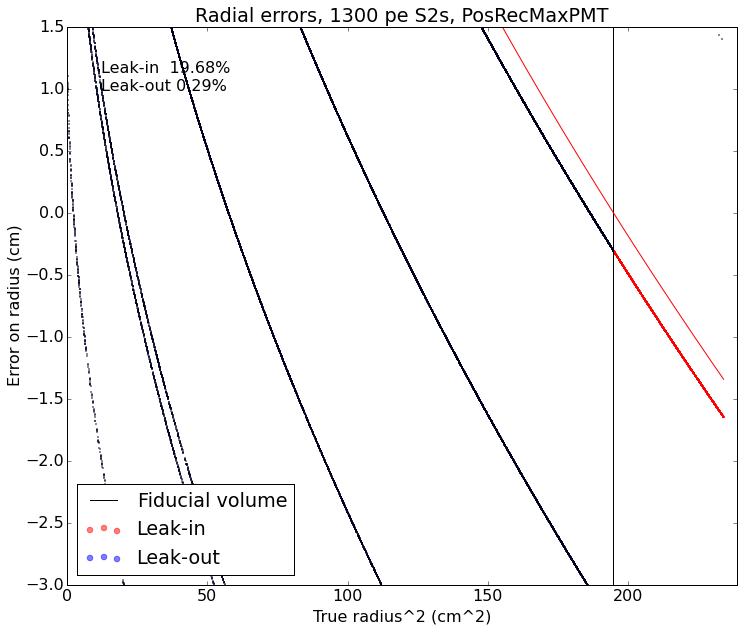

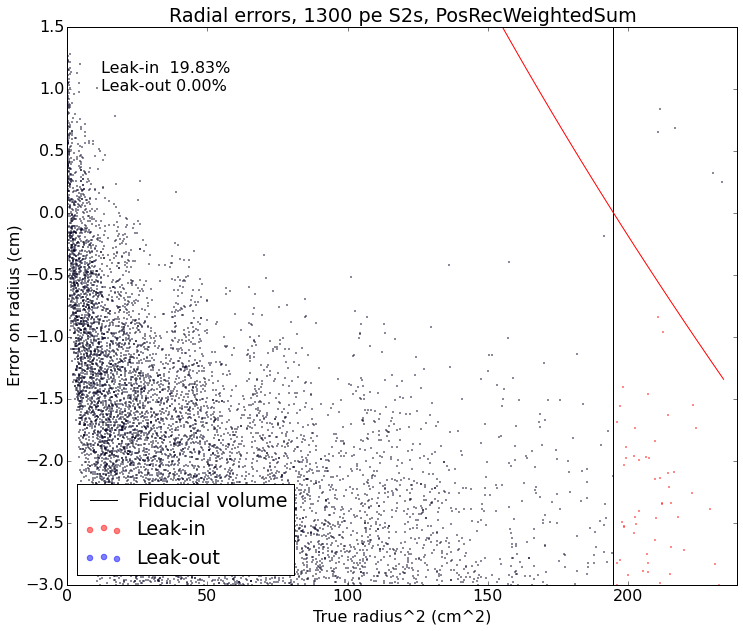

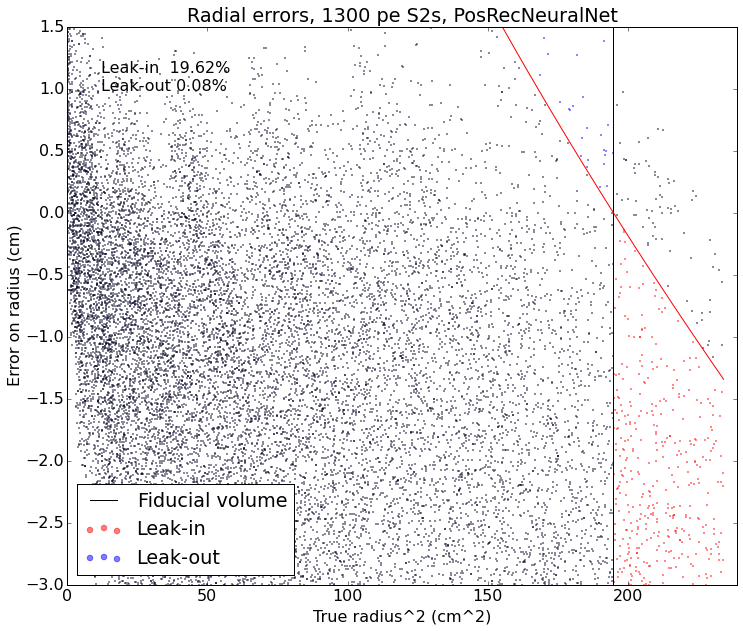

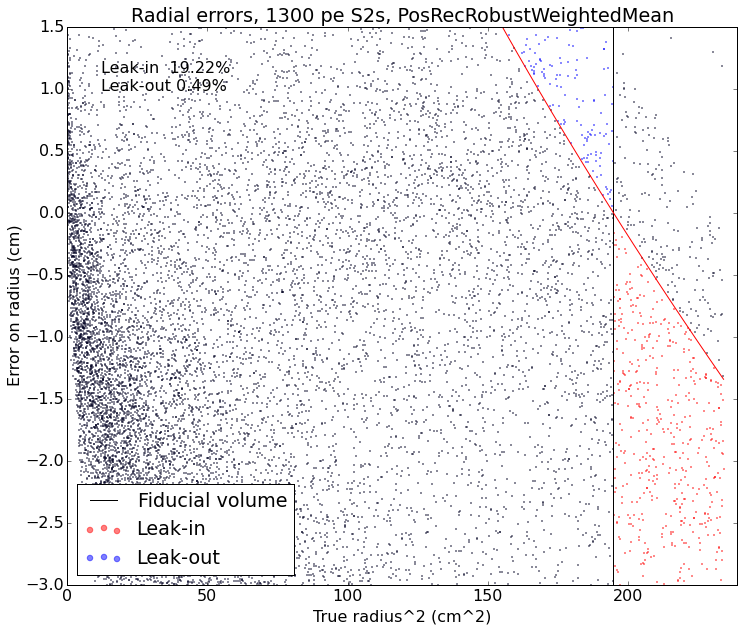

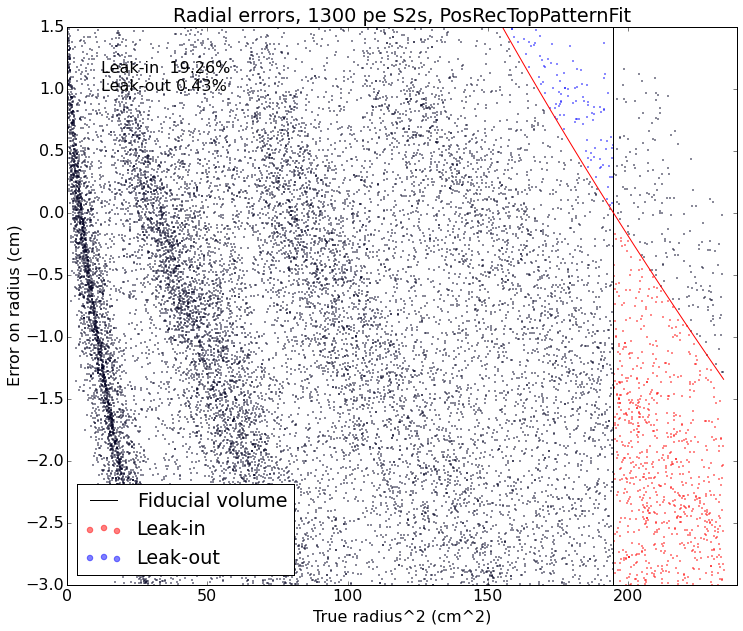

In [11]:
##
# Radial errors scatter plot
##
for pp in posrec_plugins:
    pp_name = pp.name
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    leak_in =  (rs > fiducial_volume_radius) & (rs_rec < fiducial_volume_radius)
    leak_out = (rs < fiducial_volume_radius) & (rs_rec > fiducial_volume_radius)
    
    plt.scatter(rs[leak_in]**2, 
                radial_errors[leak_in], 
                s=1, alpha=0.5, label='Leak-in', color='red')
    
    plt.scatter(rs[leak_out]**2, 
                radial_errors[leak_out], 
                s=1, alpha=0.5, label='Leak-out', color='blue')
    
    plt.scatter(rs[True ^ (leak_out | leak_in)]**2, 
                radial_errors[True ^ (leak_out | leak_in)], 
                s=1, alpha=0.5)
    
    message = "Leak-in  %0.2f%%\nLeak-out %0.2f%%" % (
            100 * len(np.where(leak_in)[0])/len(np.where(rs < fiducial_volume_radius)[0]),
            100 * len(np.where(leak_out)[0])/len(np.where(rs < fiducial_volume_radius)[0]))
    plt.text(0.05, 0.91, message,
         horizontalalignment='left',
         verticalalignment='center',
         transform = plt.gca().transAxes)
                                                    
    plt.axvline(fiducial_volume_radius**2, color='black', 
                label='Fiducial volume')

    rarg = np.linspace(0, detector_radius, 100)
    error_for_fv = fiducial_volume_radius - rarg    
    plt.plot(rarg**2, error_for_fv, color='red')
    
    plt.xlim(0, 1.02*detector_radius**2)
    plt.ylim(-3, 1.5)
    plt.xlabel('True radius^2 (cm^2)')
    plt.ylabel('Error on radius (cm)')
    leg = plt.legend(loc='lower left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Radial errors, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)
    plt.show()

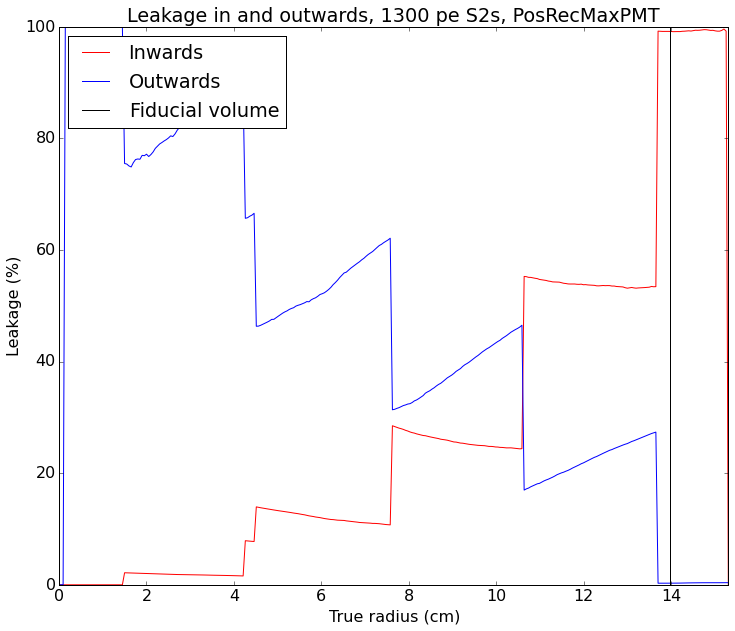

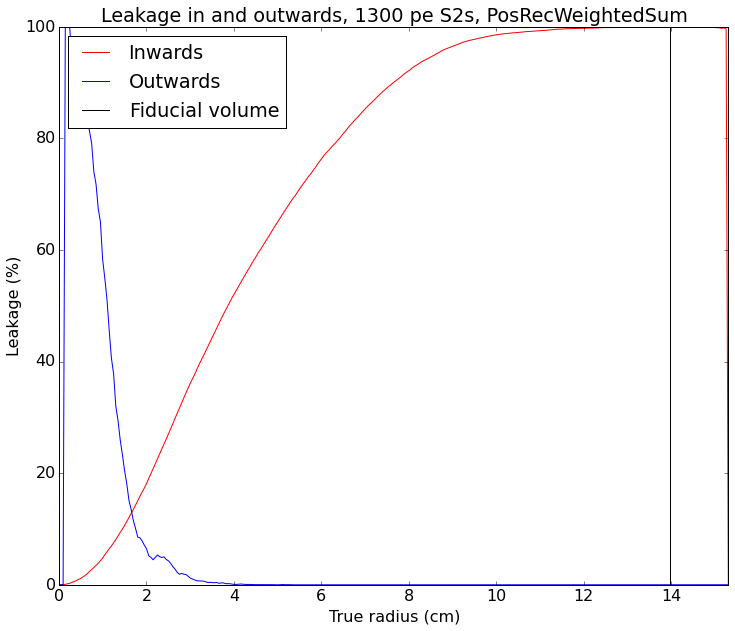

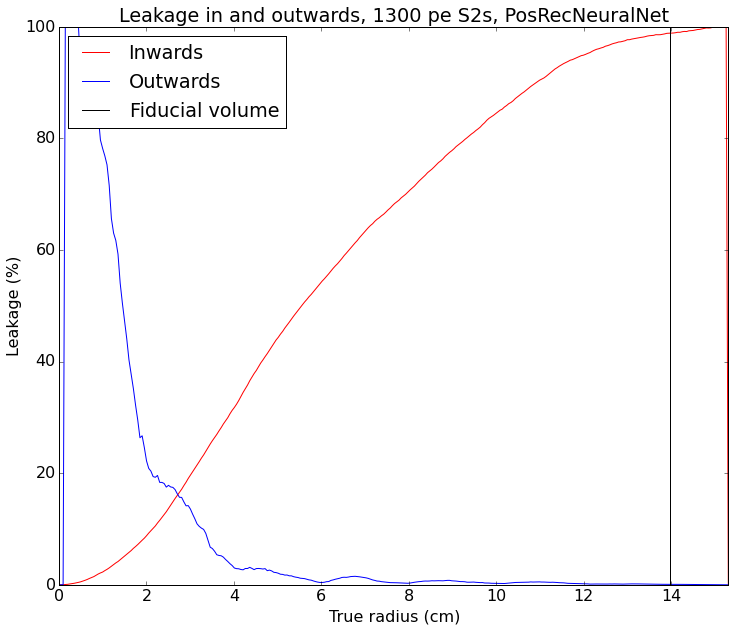

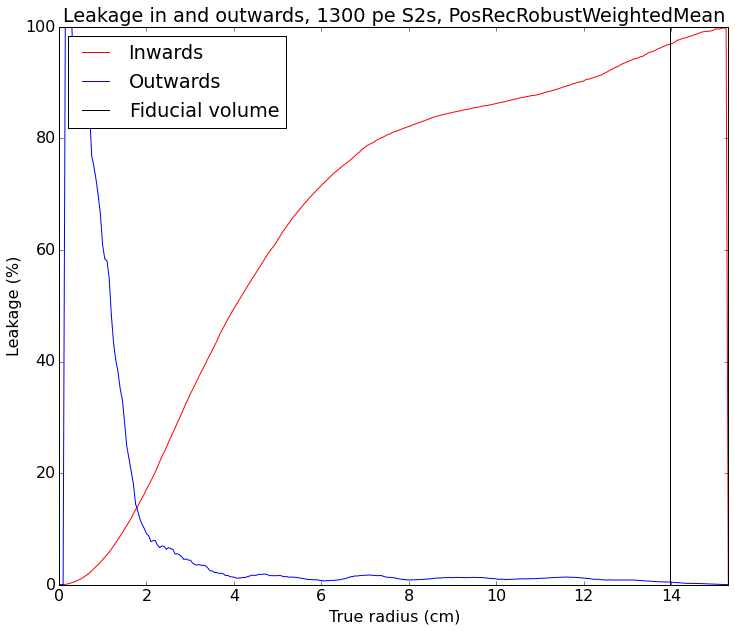

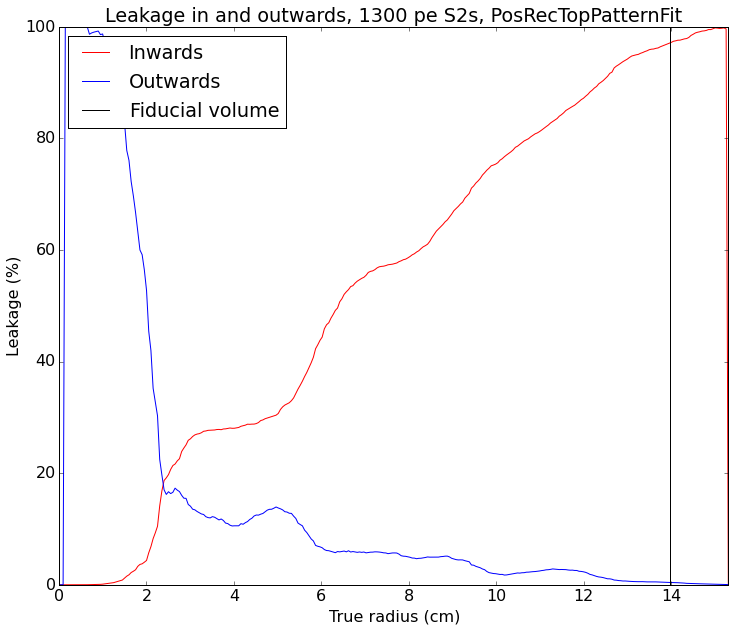

In [12]:
##
# Leakage plot
##

def leakage_percentages(rs, rs_rec, r):
    """
    rs: true radial positions
    rs_rec: reconstructed radial positions
    r: radius/radii to test ro test
    returns 2-tuple /array of 2-tuples with (leak_in, leak_out) info:    
        leak_in  = % events outside the radius, that are reconstructed inside
        leak_out = % of events inside the radius, that are reconstructed outside
    """
    # Allow calling with one radius or several radii
    try:
        r[0]
    except TypeError:
        r = [r]
    leakage_in = []
    leakage_out = []
    for radius in r:
        n_outside = np.count_nonzero(rs > radius)
        n_inside = np.count_nonzero(rs < radius)
        n_leak_in =  np.count_nonzero((rs > radius) & (rs_rec < radius))
        n_leak_out = np.count_nonzero((rs < radius) & (rs_rec > radius))
        leakage_in.append(100 * n_leak_in/n_outside if n_outside > 0 else 0)
        # Sander was dividing by n_outside here: bug or feature?
        leakage_out.append(100 * n_leak_out/n_inside if n_inside > 0 else 0)
    return leakage_in, leakage_out

for pp in posrec_plugins:
    pp_name = pp.name
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    r = np.linspace(0, detector_radius, int(detector_radius/(0.5 * units.mm)))
    inwards, outwards = leakage_percentages(rs,rs_rec,r)
    plt.plot(r, inwards, label = 'Inwards', color='red')
    plt.plot(r, outwards, label = 'Outwards', color='blue')
    
    plt.axvline(fiducial_volume_radius, color='black', 
            label='Fiducial volume')

    plt.xlabel('True radius (cm)')
    plt.ylabel('Leakage (%)')
    plt.ylim(0,100)
    plt.xlim(0,detector_radius)
    leg = plt.legend(loc='upper left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Leakage in and outwards, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)
    plt.show()

In [13]:
## Save simulated data
# np.savez_compressed("%s_posrectest_data_%dpe_%dtrials" % (strftime("%Y%m%d"), n_pe, n_trials),
#                     xs=xs,
#                     ys=ys,
#                     rps=rps,
#                     differences=differences)

In [14]:
## Load previously simulated data
# data = np.load('20150801_posrectest_data_1000pe_1000trials.npz')
# xs = data['xs']
# ys = data['ys']
# rps = data['rps'].item()
# differences = data['differences'].item()
# data.close()